# QNetGAN v3.0
Quantum `APPNP` and `MFConv` layers adapted from PyTorch Geometric, combined with self-developed `QuantumX`™️ layers that leverage the power of **Quantum Computing** to generate molecular graphs.      
Original Creator: Max     
Co-creators: None    

Last Updated: 18:08:40 Thursday April 11 (PST / UTC -7)

### Imports + CLI Stuff

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch_geometric as pyg
import torch_geometric.nn as gnn
import torch_geometric.transforms as T
import torcheval.metrics as metrics
import rdkit
import networkx as nx
import pennylane as qml
import warnings
import matplotlib.pyplot as plt
import time

from pennylane import numpy as np
from torch_geometric.datasets import QM9
from torch_geometric.utils import train_test_split_edges, to_networkx
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, AllChem
from torch.optim import Adam
from torch.optim.lr_scheduler import (
    CosineAnnealingLR, #for discriminator only
    PolynomialLR, 
    CosineAnnealingWarmRestarts, #for generator only
    ChainedScheduler
)

RDLogger.DisableLog("rdApp.*")
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LATENT_DIM = 64

print(f"PyTorch Version {torch.__version__}")
print(f"Pennylane Version {qml.__version__}")
print(f"PyTorch Geometric Version {pyg.__version__}")
print(f"NetworkX Version {nx.__version__}")
print(f"RDKit Version {rdkit.__version__}")

PyTorch Version 2.2.1+cu121
Pennylane Version 0.30.0
PyTorch Geometric Version 2.5.2
NetworkX Version 3.1
RDKit Version 2022.09.5


In [2]:
from scipy.linalg import fractional_matrix_power

def getA_norm(mol):
    mol = Chem.AddHs(mol)
    A = Chem.GetAdjacencyMatrix(mol, useBO=True)

    # Set diagonals to 1 (to add self loops)
    np.fill_diagonal(A, 1)

    # Calculate the Degree Matrix
    # we can get this as laplacian + adjacency
    graph = nx.from_numpy_array(A)
    L = nx.laplacian_matrix(graph).toarray()
    N = len(graph) # num of verts

    D = L + A
    D5 = fractional_matrix_power(D, -0.5)

    A_norm = np.matmul(np.matmul(D5, A), D5)
    return torch.Tensor(A_norm)

## QM9 Dataset
Normalized for faster training.

In [3]:
DS = QM9(root = '', transform = pyg.transforms.NormalizeFeatures())
samples = [i for i in range(12000, 23201) if DS[i].x.shape[0] == 16]

In [4]:
BATCH = 8

choice = [np.random.choice(samples) for _ in range(BATCH * 2)]

data = [DS[x] for x in choice]
mols = [Chem.MolFromSmiles(x.smiles) for x in data]

for i in range(BATCH * 2): print(f'Molecule #{choice[i]}, {data[i].smiles}')

Molecule #22792, [H]ONC1C([H])([H])[C@@]2([H])O[C@@]2([H])[C@@]1([H])O[H]
Molecule #19050, [H]C1([H])C([H])([H])C12C(=O)[C@@]1([H])C([H])([H])[C@@]21[H]
Molecule #20455, [H]OC1=C(C([H])([H])C([H])([H])[H])N([H])N=C1[H]
Molecule #18969, [H]OC([H])([H])[C@@]1([H])[C@@]2([H])O[C@@]2([H])[C@@]1([H])O[H]
Molecule #14534, [H]OC([H])([H])[C@@]1([H])N([H])C([H])([H])[C@@]1([H])C#N
Molecule #14629, [H]C(=O)[C@]1([H])OC([H])([H])OC([H])([H])C1([H])[H]
Molecule #18552, [H]C1([H])[C@]2([H])O[C@]3([H])[C@@]1([H])O[C@]3([H])C2([H])[H]
Molecule #12692, [H][N-]C1OC([H])([H])[C@]2([H])N([H])[C@]12C([H])([H])[H]
Molecule #12447, [H]O[C@@]12C([H])([H])O[C@]1([H])C([H])([H])[C@]2([H])O[H]
Molecule #19824, [H]C1([H])[C@]2([H])[C@]3([H])O[C@@]1([H])[C@@]1([H])[C@]3([H])[C@@]21[H]
Molecule #14714, [H]C(=O)C([H])(C([H])=O)C1([H])C([H])([H])C1([H])[H]
Molecule #21835, [H]ONC1C([H])([H])C(=O)OC([H])([H])C1([H])[H]
Molecule #12421, [H]C1([H])O[C@]2(C([H])([H])[H])C(=O)C([H])([H])[C@]12[H]
Molecule #16116, [H]O[C

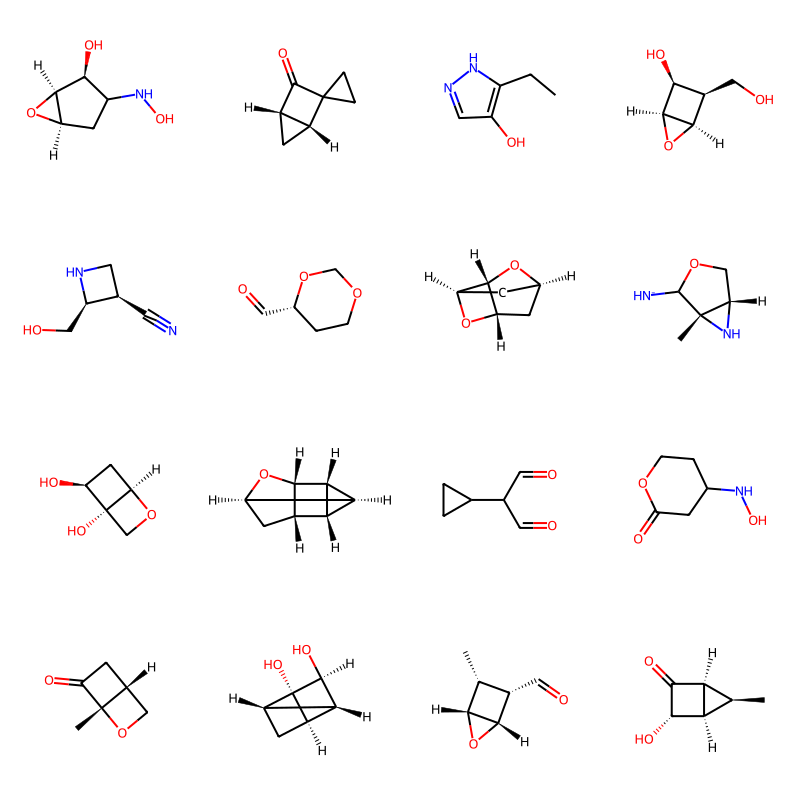

In [5]:
Chem.Draw.MolsToGridImage(mols, maxMols = BATCH * 2, molsPerRow = 4)

In [6]:
for i in range(BATCH * 2):
    data[i].train_mask = data[i].val_mask = data[i].test_mask = None
    data[i] = train_test_split_edges(data[i])

In [7]:
adjacency = [getA_norm(M) for M in mols]
batched = []

for i in range(2 * BATCH):
    x = adjacency[i]
    if x.size() == (16, 16):
        batched.append((x.to(device), data[i].train_pos_edge_index.to(device)))

## Quantum Layers
I'm thinking a Quantum LSTM and a regular Quantum layer (replaces `nn.Linear`) as we make the transition towards a fully-quantum model. Right now, the main goal is to increase the proportion of quantum computing. 

In [8]:
from qlayers import QuantumDenseLayer, QLSTMCell

When using these layers, follow this structure 

```python
QLSTM = QLSTMCell(input_size=7, hidden_size=128, n_qubits=7)
QDL = QuantumDenseLayer(wires=7)

z = nn.Linear(data.x.shape[-1], 128)(data.x)
z = QDL(z)
z = QLSTM(z)
z
```

### Classical Graph Layers
I'm thinking we use `MFConv` from `PyTorch Geometric`, since it's better suited for molecular graphs. We can try combining this with regular `GCNConv` layers, as well as the `APPNP`.   

Resources: [MFConv paper](https://arxiv.org/abs/1509.09292) and [APPNP paper](https://arxiv.org/abs/1810.05997)

## Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int = 1,
        use_bias = True,
        dropout = 0.0,
    ) -> None:
        
        super(Discriminator, self).__init__()
        
        n_qubits = int(np.log2(hidden_channels))
        self.qdl = QuantumDenseLayer(n_qubits)
        self.lstm = QLSTMCell(n_qubits, hidden_channels, n_qubits)
        self.foutput = nn.Linear(hidden_channels, out_channels)
        
        self.hidden_channels = hidden_channels
        self.dropout = dropout
        
    def forward(self, x):
        z = nn.Linear(x.shape[-1], 128)(x)
        z = self.qdl(z) #pass through quantum layer
        z = self.lstm(z) #pass through LSTM
        z = nn.AdaptiveAvgPool1d(1)(z).squeeze(dim=-1) #global average pooling
        z = nn.Linear(z.shape[-1], self.hidden_channels)(z) #expand again
        
        z = nn.ReLU()(z) #rectified linear unit activation
        z = nn.Dropout(p=self.dropout)(z) #dropout
        z = self.foutput(z) #aggregate into single output
        return z
    

In [10]:
D = Discriminator(16, 2 * LATENT_DIM)

## Generator
Using `MFConv`, `GCNConv`, and `APPNP`. Unfortunately this means we can't make these quantum, but that's okay because we still have out `QLSTMCell` from above, as well as the `QuantumDenseLayer`

In [11]:
class Generator(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        appnp: bool = False, 
    ):
        
        super(Generator, self).__init__()
        
        self.molecular = gnn.conv.MFConv(
            in_channels = in_channels,
            out_channels = 2 * out_channels,
            max_degree = 4,
            bias = True
        )
        
        self.conv = gnn.conv.GCNConv(
            in_channels = 2 * out_channels,
            out_channels = out_channels,
            normalize = True,
            bias = True
        )

        self.propagate = gnn.conv.APPNP(
            K = 1, 
            alpha = 0.0,
            dropout = 0.0,
            cached = True,
            normalize = True,
        )
        
        n_qubits = int(np.log2(out_channels))
        self.qdl = QuantumDenseLayer(n_qubits)
        self.lstm = QLSTMCell(n_qubits, out_channels, n_qubits)
        
        #Model properties
        self.use_appnp = appnp
        
    def forward(self, x, edge_index):
        z = self.molecular(x, edge_index)
        if self.use_appnp: z = self.appnp(z, edge_index)
        z = self.conv(z, edge_index)
        z = self.qdl(z)
        z = self.lstm(z)

        z = nn.LeakyReLU()(z)
        adjacency = torch.matmul(z, z.t())
        return adjacency

In [12]:
G = Generator(16, LATENT_DIM)

## Build the WGAN-GP Model

In the process of changing this work with batched data, which helps prevent the loss from jumping around like a monkey.

In [13]:
class WGAN_GP(nn.Module):
    def __init__(
        self,
        generator: nn.Module = None,
        discriminator: nn.Module = None,
    ) -> None:
        
        super(WGAN_GP, self).__init__()
        self.G = generator
        self.D = discriminator

        assert(generator == None, "Generator is missing")
        assert(discriminator == None, "Discriminator is missing")
        
        #optimizers
        self.opt_gen = torch.optim.Adam(self.G.parameters(), lr=1e-4)
        self.opt_disc = torch.optim.Adam(self.D.parameters(), lr=1e-4)
        
        #learning rate schedulers
        scheduler_g1 = PolynomialLR(
            optimizer = self.opt_gen,
            total_iters = 5,
            power = 2.0, #adjacency matrix is quadratic
        )
        
        scheduler_g2 = CosineAnnealingWarmRestarts(
            optimizer = self.opt_gen, T_0 = 5,
        )
        
        self.scheduler_gen = ChainedScheduler([scheduler_g1, scheduler_g2])
        
        scheduler_d1 = PolynomialLR(
            optimizer = self.opt_disc,
            total_iters = 5,
            power = 2.0, #adjacency matrix is quadratic
        )
        
        scheduler_d2 = CosineAnnealingLR(
            optimizer = self.opt_disc, T_max = 5,
        )
        
        self.scheduler_disc = ChainedScheduler([scheduler_d1, scheduler_d2])
        
        #loss metrics
        self.metricG = metrics.Mean()
        self.metricD = metrics.Mean()
        
        #records of loss
        self.Gtracker = []
        self.Dtracker = []
        
    def train(self, adjacency, edge_index, epochs: int=10):
        '''
        Trains the model for `epoch` number of epochs.
        Default is 10 epochs. `epochs` is capped at 10 due to ASDRP server issues!
        '''
        if len(adjacency) != len(edge_index):
            raise ValueError("Adjacency and edge_index must have the same length!")
        
        batch_size = len(adjacency)
        train_start = time.time()
        starttime = time.time()
        epoch = 1

        while epoch <= epochs:
            epoch_gen_loss = 0.
            epoch_disc_loss = 0.
            
            for b in range(batch_size):
                self.D.zero_grad()
                gaussian = torch.rand_like(adjacency[b])
                adj_fake = self.G(gaussian, edge_index[b])
                if not adj_fake.requires_grad: adj_real.requires_grad_(True)
                self.opt_disc.zero_grad()
                disc_loss = self.discriminator_loss(adjacency[b], adj_fake)
                disc_loss.backward()
                self.opt_disc.step()
                self.scheduler_disc.step()
                #_ = self.metricD.update(disc_loss).compute() #apparently this does nothing
                
                self.G.zero_grad()
                gaussian = torch.rand_like(adjacency[b])
                adj_fake = self.G(gaussian, edge_index[b])
                if not adj_fake.requires_grad: adj_real.requires_grad_(True)
                self.opt_gen.zero_grad()
                gen_loss = self.generator_loss(adjacency[b])
                gen_loss.backward()
                self.opt_gen.step()
                self.scheduler_gen.step()
                #_ = self.metricG.update(gen_loss).compute() #apparently this does nothing
                
                epoch_gen_loss += gen_loss
                epoch_disc_loss += disc_loss
            
            #Display
            curr_time = time.time()
            print(f"EPOCH: {epoch}\tDiscriminator Loss: {epoch_disc_loss.item()/8:.6f}", end='')
            print(f"\tGenerator Loss: {epoch_gen_loss.item()/8:.6f}\tTime: {curr_time - starttime:.4f}s")
            self.Gtracker.append(epoch_gen_loss.item())
            self.Dtracker.append(epoch_disc_loss.item())

            epoch += 1
            starttime = curr_time
            
        #we finally done!
        print(f"Training Completed! Elapsed time: {time.time() - train_start:.4f}s")
                
        #plot multiple graphs actually lol
        plt.figure(figsize=(8, 6))
        plt.suptitle("Generator and Discriminator Loss During Training")
        fig, (ax1, ax2) = plt.subplots(2)
        
        ax1.plot(range(epochs), self.Gtracker, label="Generator")
        ax2.plot(range(epochs), self.Dtracker, label="Discriminator")
        
        plt.show()
        
        return
    
    #Tested successfully
    @torch.no_grad()
    def sample(self, A, edge_index):
        '''
        Samples from the latent space. Returns a probabilistic adjacency matrix.
        '''
        gaussian_noise = torch.rand_like(A)
        adjacency = self.G(gaussian_noise, edge_index)
        adjacency = adjacency.cpu().detach()
        adjacency = adjacency.fill_diagonal_(0)
        return adjacency
    
    #TODO
    def octet_penalty(self, adj_fake):
        '''
        Implements octet penalty based on number of problematic vertices
        (vertices with degree > 4) in the graph
        to motivate generator to produce more sparse graphs
        '''
        if not adj_fake.requires_grad: adj_fake.requires_grad_(True)
        return 0.0
    
    #Tested succesfully - gradients are nonzero and non-null
    def gradient_penalty(self, adj_real, adj_fake):
        '''
        Implements gradient penalty to enforce the Lipschitz Constraint
        '''
        if not adj_real.requires_grad: adj_real.requires_grad_(True)
        if not adj_fake.requires_grad: adj_fake.requires_grad_(True)
        alpha = torch.randn((1, 1))
        alpha.expand_as(adj_real)
        
        #interpolate the real and the fake adjacency matrices
        interpolated = alpha * adj_real + (1 - alpha) * adj_fake
        try: grape =  interpolated.requires_grad
        except AttributeError:
            interpolated = autograd.Variable(interpolated, requires_grad=True)
            
        #pass through discriminator
        logits = self.D(interpolated)
        logits.backward(retain_graph = True)
    
        #temporary workaround
        gradients = autograd.grad(
            logits,
            interpolated,
            #create_graph=True,
            #retain_graph=True,
            #allow_unused=True,
            materialize_grads=True,
        )
        
        #calculate penalty
        penalty = (1 - torch.norm(gradients[0], dim=-1)) ** 2
        return torch.mean(penalty, dim=(-1))
    
    #Tested successfully
    def generator_loss(self, adjacency):
        '''
        Generator loss function
        '''
        if not adjacency.requires_grad: adjacency.requires_grad_(True)
        logits = self.D(adjacency)
        return -1 * (torch.mean(logits)) #mean of an element is the element so...
    #negative losses are OK
    
    #Tested successfully
    def discriminator_loss(self, adj_real, adj_fake, gp_weight = 6.9420):
        if not adj_real.requires_grad: adj_real.requires_grad_(True)
        if not adj_fake.requires_grad: adj_fake.requires_grad_(True)
        logits = [self.D(adj_real), -1 * self.D(adj_fake)]
        loss = sum(logits)
        grad_pen = self.gradient_penalty(adj_real, adj_fake)
        return loss + gp_weight * grad_pen

In [81]:
QNetGAN = WGAN_GP(
    generator = G,
    discriminator = D,
)

QNetGAN = QNetGAN.to(device)

QNetGAN

WGAN_GP(
  (G): Generator(
    (molecular): MFConv(16, 128)
    (conv): GCNConv(128, 64)
    (propagate): APPNP(K=1, alpha=0.0)
    (qdl): <Quantum Torch Layer: func=PQC>
    (lstm): QLSTMCell(
      (cell): Linear(in_features=6, out_features=6, bias=True)
    )
  )
  (D): Discriminator(
    (qdl): <Quantum Torch Layer: func=PQC>
    (lstm): QLSTMCell(
      (cell): Linear(in_features=7, out_features=7, bias=True)
    )
    (foutput): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [82]:
train_adj = [batched[i][0] for i in range(4,8)]
train_ei = [batched[i][1] for i in range(4,8)]
#BATCH = 8 is too slow since we don't have GPU

EPOCH: 1	Discriminator Loss: 3.463058	Generator Loss: 0.022204	Time: 53.6689s
EPOCH: 2	Discriminator Loss: 3.473901	Generator Loss: 0.006480	Time: 54.2533s
EPOCH: 3	Discriminator Loss: 3.498325	Generator Loss: -0.014422	Time: 54.3825s
EPOCH: 4	Discriminator Loss: 3.467703	Generator Loss: -0.007133	Time: 54.2204s
EPOCH: 5	Discriminator Loss: 3.442032	Generator Loss: 0.018749	Time: 54.3072s
EPOCH: 6	Discriminator Loss: 3.441721	Generator Loss: 0.007964	Time: 54.3399s
EPOCH: 7	Discriminator Loss: 3.457438	Generator Loss: 0.017411	Time: 54.4157s
EPOCH: 8	Discriminator Loss: 3.465127	Generator Loss: 0.008603	Time: 54.3435s
Training Completed! Elapsed time: 433.9316s


<Figure size 800x600 with 0 Axes>

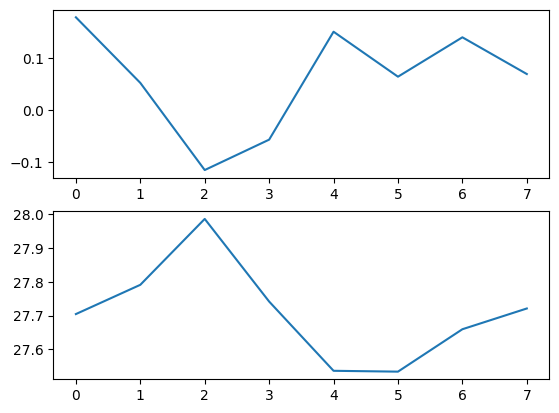

In [83]:
QNetGAN.train(train_adj, train_ei, 8)

In [141]:
np.random.seed(408)

Molecules with too many bonds 1 5 6 8 12 13
Removing molecules...
Adding edges to reconnect graph...
	Added edge from 10 to 11
	Added edge from 3 to 4
	Added edge from 10 to 7
	Added edge from 9 to 3
	Added edge from 15 to 11
	Added edge from 15 to 7
	Added edge from 15 to 0


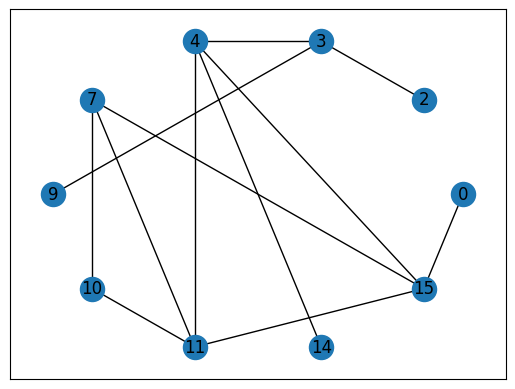

In [146]:
sample = QNetGAN.sample(batched[8][0], batched[8][1]).detach().cpu().numpy()
sample /= np.max(sample)
sample = np.abs(sample) #probs can't be negative
#also scientific notation is sus
N = sample.shape[0]

for row in range(N):
    for col in range(row + 1, N):
        p_edge = sample[row][col]
        if p_edge <= 1e-3: p_edge *= 10.0
        if p_edge <= 1e-2: p_edge *= 9.5
        probabilities = sorted([1 - p_edge, p_edge])
        sample[row][col] = np.random.choice([1., 0.], p=probabilities) #no double/triple for now
        sample[col][row] = sample[row][col]

graph = nx.from_numpy_array(sample, parallel_edges=True)
#nx.draw_networkx(graph, pos=nx.circular_layout(graph))

degrees = dict(graph.degree())
problematic = [x for x in degrees.keys() if degrees[x] > 4]
degrees = list(degrees.values())
print("Molecules with too many bonds", *problematic)
print("Removing molecules...")

graph.remove_nodes_from(problematic)
#nx.draw_networkx(graph, pos=nx.circular_layout(graph))

print("Adding edges to reconnect graph...")
while not nx.is_connected(graph):
    start = np.random.choice(list(graph.nodes()))
    while graph.degree(start) == 4:
        start = np.random.choice(list(graph.nodes()))
    
    end = np.random.choice(list(graph.nodes()))
    while graph.degree(end) == 4 and end == start:
        end = np.random.choice(list(graph.nodes()))

    if end == start: continue
    print(f"\tAdded edge from {start} to {end}")
    graph.add_edges_from([(start, end)])
    if graph.degree(start) > 4 or graph.degree(end) > 4:
        graph.remove_edges_from([(start, end)])

nx.draw_networkx(graph, pos=nx.circular_layout(graph))

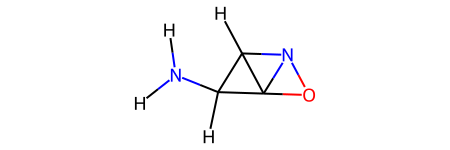

In [147]:
atom_map = {
    4 : Chem.Atom("C"),
    3 : Chem.Atom("N"),
    2 : Chem.Atom("O"),
    1 : Chem.Atom("H"),
}
graph_atoms = dict(graph.degree())

new_adjacency = nx.to_numpy_array(graph)
N = len(new_adjacency)
molecule = Chem.RWMol()

for value in graph_atoms.values():
    molecule.AddAtom(atom_map[value])
    
for row in range(N):
    for col in range(1+row, N):
        if new_adjacency[row][col] == 1:
            molecule.AddBond(row, col)

while True:
    hindex = [i for i, x in enumerate(molecule.GetAtoms()) if x.GetSymbol() == 'H']
    try:
        molecule.RemoveAtom(hindex[-1])
        hindex.pop()
    except IndexError: break

molecule = Chem.AddHs(
    molecule,
    explicitOnly = True,
    addCoords = True
)

smiles = Chem.MolToSmiles(molecule)
smiles = smiles.replace('~', '')
molecule = Chem.MolFromSmiles(smiles)
molecule = Chem.AddHs(molecule)
molecule

In [148]:
Lipinski = [
    Descriptors.MolWt(molecule) <= 500,
    Descriptors.NOCount(molecule) <= 10,
    Descriptors.NHOHCount(molecule) <= 5,
    Descriptors.MolLogP(molecule) <= 5
].count(True) >= 3

print(Lipinski, end=' ')

conformer_id = AllChem.EmbedMolecule(
    molecule,
    #randomSeed = 54500,
    clearConfs = True,
    #useRandomCoords = True,
    maxAttempts = 50,
    numZeroFail = 4,
    ignoreSmoothingFailures = True
)
status = AllChem.UFFOptimizeMolecule(molecule)
print(conformer_id, status)

True 0 0


In [149]:
with open('validmols.txt', 'a') as F:
    F.write(smiles + '\n')
    F.close()

with open('Valid Molecules (R18)/R18473.xyz', 'w') as fout:
    for pos, atom in enumerate(molecule.GetAtoms()):
        positions = molecule.GetConformer(conformer_id).GetAtomPosition(pos)
        fout.write(f"{atom.GetSymbol()}\t{positions.x}\t{positions.y}\t{positions.z}")
        fout.write('\n')
    fout.close()

$78$ out of $85$ valid molecules!   